In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score, precision_score, confusion_matrix, precision_recall_curve, roc_curve, f1_score
from sklearn.inspection import permutation_importance

Load boxscore_df

In [4]:
boxscore_df = pd.read_csv('boxscore_df')
boxscore_df.head()

,Unnamed: 0,id_x,name,id_y,game_id,team_id,player_id,position,player_name,goals,...,caused_turnovers,faceoffs_won,faceoffs_taken,penalties,penalty_time,goalie_seconds,goals_allowed,goalie_saves,created_at,updated_at
0,0,2,Binghamton,4712,1,2,41.0,D,Chris Bechle,0,...,0,0,0,1,30,0,0,0,2023-10-24 16:37:17.319077,2023-10-24 16:37:17.319077
1,1,2,Binghamton,4713,1,2,48.0,D,George Diegnan,0,...,0,1,2,0,0,0,0,0,2023-10-24 16:37:17.319077,2023-10-24 16:37:17.319077
2,2,2,Binghamton,4714,1,2,51.0,D,Sean Finnigan,0,...,0,0,0,0,0,0,0,0,2023-10-24 16:37:17.319077,2023-10-24 16:37:17.319077
3,3,2,Binghamton,4715,1,2,57.0,M,Matt Kaser,0,...,0,0,0,0,0,0,0,0,2023-10-24 16:37:17.319077,2023-10-24 16:37:17.319077
4,4,2,Binghamton,4716,1,2,63.0,M,Anthony Lombardo,0,...,0,0,0,0,0,0,0,0,2023-10-24 16:37:17.319077,2023-10-24 16:37:17.319077


In [3]:
boxscore_df.shape

(1180290, 28)

Let's look at total goals by position

In [4]:
boxscore_df.groupby('position')['goals'].sum()

position
A    116019
D      2530
G       127
M     55449
Name: goals, dtype: int64

This makes sense. Most of the goals are scored by Attackers and Midfielders with a handful by Defenders and a couple by Goalies. I wonder what the counts by position are.

In [5]:
boxscore_df.groupby('position')['player_id'].count()

position
A    69311
D    73686
G    32902
M    72669
Name: player_id, dtype: int64

This also makes sense. Each team is typically comprised of three A's, M's, and D's with one G. 

Create a new df for the classifier to include only the stats that are being taken into consideration. Then remove all blank entries.

In [5]:
df = boxscore_df[['position',
       'goals', 'assists', 'points', 'shots', 'shots_on_goal',
       'ground_balls', 'turnovers',
       'caused_turnovers', 'faceoffs_won', 'faceoffs_taken', 'penalties',
       'penalty_time', 'goalie_seconds', 'goals_allowed', 'goalie_saves']]

df_noblanks = df[df['position'] != '']
df_noblanks = df_noblanks.dropna()

In [4]:
#df.head(10)

Compare the shapes of the overall df to the one without blanks.

In [7]:
df.shape, df_noblanks.shape

((1180290, 16), (248616, 16))

~21% of the data points are not blank. Although, that's a low percentage, it's based on 1.1 millions rows of data. There are plenty of data points to train and test on.

In [6]:
X = df_noblanks.drop('position', axis=1).values
y = df_noblanks['position'].values

Create training and testing sets with default parameters

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Chose not to scale the data first. Would it make a difference? Maybe check later...

Starting low by checking scores for neighbors 1-19

In [22]:
for n in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    print('n= ', n)
    print('score= ', knn.score(X_test, y_test))  #with player ID; 1 = 71.5, 3 = 69.9
#knn = KNeighborsClassifier(n_neighbors=3)
#knn.fit(X_train, y_train)

n=  1
score=  0.6459278566142163
n=  2
score=  0.7027222704894295
n=  3
score=  0.6934388776265406
n=  4
score=  0.7112333880361682
n=  5
score=  0.7087395823277666
n=  6
score=  0.7230427647456318
n=  7
score=  0.7194388132702642
n=  8
score=  0.7250860765196125
n=  9
score=  0.7234289024037069
n=  10
score=  0.7281429996460405
n=  11
score=  0.7265662708755671
n=  12
score=  0.7298967081764649
n=  13
score=  0.7266949834282589
n=  14
score=  0.730073687936416
n=  15
score=  0.7285613154422885
n=  16
score=  0.7297197284165138
n=  17
score=  0.7299288863146378
n=  18
score=  0.7321813559867426
n=  19
score=  0.730524181870837


Not bad, but we can do better. With all this data, let's expand the neighbors search to 1000

In [13]:
knnscores = []
for n in range(10, 1001, 50):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    knnscores.append((n, knn.score(X_test, y_test)))
    print('n= ', n)
    print('score= ', knn.score(X_test, y_test)) 

n=  10
score=  0.7281429996460405
n=  60
score=  0.7362840686037906
n=  110
score=  0.7391801010393538
n=  160
score=  0.7387456961740194
n=  210
score=  0.7388422305885382
n=  260
score=  0.7372333236798919
n=  310
score=  0.7367989188145574
n=  360
score=  0.7367184734691251
n=  410
score=  0.7364610483637417
n=  460
score=  0.7360105544293207
n=  510
score=  0.735914020014802
n=  560
score=  0.7351095665604788
n=  610
score=  0.7355439714258133
n=  660
score=  0.7351095665604788
n=  710
score=  0.7343051131061556
n=  760
score=  0.7347395179714902
n=  810
score=  0.7341120442771182
n=  860
score=  0.7333236798918814
n=  910
score=  0.7329214531647199
n=  960
score=  0.7322778904012613


It seems the ideal range is between 60-210

In [14]:
knnscores_60_210 = []
for n in range(60, 211, 10):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    knnscores_60_210.append((n, knn.score(X_test, y_test)))
    #print('n= ', n)
    #print('score= ', knn.score(X_test, y_test)) 
print('done')

done


In [19]:
#sorted(knnscores, key=lambda x:x[1], reverse=True)

Narrowing down the range from 170 - 190

In [20]:
knnscores_170_190 = []
for n in range(170, 191):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    knnscores_170_190.append((n, knn.score(X_test, y_test)))
print('done')

done


In [21]:
sorted(knnscores_170_190, key=lambda x:x[1], reverse=True)

[(180, 0.7396145059046884),
 (170, 0.7395018824210832),
 (171, 0.7394536152138237),
 (177, 0.7394053480065643),
 (190, 0.7394053480065643),
 (186, 0.7393892589374779),
 (175, 0.7393409917302185),
 (176, 0.7393409917302185),
 (178, 0.7392766354538727),
 (184, 0.7392605463847862),
 (179, 0.7392122791775267),
 (183, 0.7392122791775267),
 (187, 0.7392122791775267),
 (188, 0.7392122791775267),
 (181, 0.7391640119702674),
 (174, 0.7389709431412298),
 (172, 0.7389548540721433),
 (173, 0.7389548540721433),
 (182, 0.7389226759339704),
 (185, 0.7386169836213277),
 (189, 0.7385365382758954)]

180 neighbors yields the highest score

fit Knn with default parms... weights = uniform

In [8]:
knn = KNeighborsClassifier(n_neighbors=180)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=180)

In [11]:
print('knn unif training accuracy: {:.4f}'.format(knn.score(X_train,y_train)))
print('knn unif test accuracy: {:.4f}'.format(knn.score(X_test, y_test)))

knn unif training accuracy: 0.74
knn unif test accuracy: 0.74


try knn with weights = distance

In [9]:
knnd = KNeighborsClassifier(n_neighbors=180, weights='distance')
knnd.fit(X_train, y_train)
print('knn dist training accuracy: {:.4f}'.format(knnd.score(X_train,y_train)))
print('knn dist test accuracy: {:.4f}'.format(knnd.score(X_test, y_test)))

knn dist training accuracy: 0.8176
knn dist test accuracy: 0.7269


Test examples must make sense. If a player scores a goal, that means they also get a point, need to take a shot, and it be a shot on goal. Similarly, if a goalie has a save or has a goal allowed, there must be goalie minutes accounted for. In addition, you can't have a faceoff won if there is not faceoff taken nor can there be penalty minutes without a penalty. These items should be considered when testing. 

233 seconds with 4 saves means your likely a goalie

In [16]:
testGK = np.array([[
       0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 
       233, 0, 4]])
#      'goals', 'assists', 'points', 'shots', 'shots_on_goal'
#       'ground_balls', 'turnovers','caused_turnovers', 'faceoffs_won', 'faceoffs_taken', 'penalties','penalty_time'
#       'goalie_seconds', 'goals_allowed', 'goalie_saves'
print(knn.predict(testGK))

['G']


<=234 goalie seconds with all zeros likely means your a goalie, >234 seconds could be a D

In [17]:
mins_G = np.array([[
       0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 
       234, 0, 0]])
print(knn.predict(mins_G))

['G']


1 goal, 1 point, 4 shots, and 1 on goal is likely a M, but 2 goals, 2 points, with 4 shots and 2 on goal is likely an A

In [18]:
twopoints = np.array([[
       2, 0, 2, 4, 2,
       0, 0, 0, 0, 0, 0, 0, 
       0, 0, 0]])
print(knn.predict(twopoints))

['A']


Time to view what knn predicts vs the actual

In [19]:
knn.predict(X_test)[:5]

array(['A', 'M', 'D', 'A', 'M'], dtype=object)

In [20]:
y_test[:5]

array(['A', 'M', 'M', 'A', 'M'], dtype=object)

I wonder if different train/test sizes will make a difference.

In [13]:
for r in range(60, 96, 5):
    print(r/100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=r/100, random_state=42)
    knn.fit(X_train, y_train)
    print('knn unif training accuracy: {:.4f}'.format(knn.score(X_train,y_train)))
    print('knn unif test accuracy: {:.4f}'.format(knn.score(X_test, y_test)))
    knnd.fit(X_train, y_train)
    print('knn dist training accuracy: {:.4f}'.format(knnd.score(X_train,y_train)))
    print('knn dist test accuracy: {:.4f}'.format(knnd.score(X_test, y_test)))
    

0.6
knn unif training accuracy: 0.7422
knn unif test accuracy: 0.7377
knn dist training accuracy: 0.8227
knn dist test accuracy: 0.7254
0.65
knn unif training accuracy: 0.7419
knn unif test accuracy: 0.7372
knn dist training accuracy: 0.8209
knn dist test accuracy: 0.7254
0.7
knn unif training accuracy: 0.7419
knn unif test accuracy: 0.7366
knn dist training accuracy: 0.8192
knn dist test accuracy: 0.7256
0.75
knn unif training accuracy: 0.7420
knn unif test accuracy: 0.7396
knn dist training accuracy: 0.8176
knn dist test accuracy: 0.7269
0.8
knn unif training accuracy: 0.7419
knn unif test accuracy: 0.7402
knn dist training accuracy: 0.8158
knn dist test accuracy: 0.7275
0.85
knn unif training accuracy: 0.7421
knn unif test accuracy: 0.7379
knn dist training accuracy: 0.8146
knn dist test accuracy: 0.7256
0.9
knn unif training accuracy: 0.7421
knn unif test accuracy: 0.7387
knn dist training accuracy: 0.8133
knn dist test accuracy: 0.7259
0.95
knn unif training accuracy: 0.7424
knn u

A KNeighbors classifer with the default parameters seems accurate. There are numerous scenarios that are in play and being ~74% accurate is acceptable...but that doesn't preclude me from trying another one. 

Going to remove the same features as in the best scoring decision tree model

Remove goals, assists, penalty time, shots on goal, goalie saves, goals allowed, faceoffs won

In [14]:
#remove goals, assists, penalty time, shots on goal, goalie saves, goals allowed, faceoffs won
X2 = df_noblanks.drop(['position','goals','assists','faceoffs_won','penalty_time','shots_on_goal','goalie_saves','goals_allowed'], axis=1).values
y2 = df_noblanks['position'].values

In [17]:
for r in range(60, 96, 5):
    print(r/100)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, train_size=r/100, random_state=42)
    knn.fit(X_train2, y_train2)
    print('knn unif training accuracy: {:.4f}'.format(knn.score(X_train2,y_train2)))
    print('knn unif test accuracy: {:.4f}'.format(knn.score(X_test2, y_test2)))
    knnd.fit(X_train2, y_train2)
    print('knn dist training accuracy: {:.4f}'.format(knnd.score(X_train2,y_train2)))
    print('knn dist test accuracy: {:.4f}'.format(knnd.score(X_test2, y_test2)))

0.6


knn unif training accuracy: 0.7425
knn unif test accuracy: 0.7384
knn dist training accuracy: 0.7793
knn dist test accuracy: 0.7285
0.65
knn unif training accuracy: 0.7422
knn unif test accuracy: 0.7373
knn dist training accuracy: 0.7785
knn dist test accuracy: 0.7279
0.7
knn unif training accuracy: 0.7418
knn unif test accuracy: 0.7363
knn dist training accuracy: 0.7770
knn dist test accuracy: 0.7279
0.75
knn unif training accuracy: 0.7416
knn unif test accuracy: 0.7381
knn dist training accuracy: 0.7758
knn dist test accuracy: 0.7296
0.8
knn unif training accuracy: 0.7416
knn unif test accuracy: 0.7392
knn dist training accuracy: 0.7746
knn dist test accuracy: 0.7298
0.85
knn unif training accuracy: 0.7415
knn unif test accuracy: 0.7378
knn dist training accuracy: 0.7737
knn dist test accuracy: 0.7297
0.9
knn unif training accuracy: 0.7418
knn unif test accuracy: 0.7355
knn dist training accuracy: 0.7730
knn dist test accuracy: 0.7273
0.95
knn unif training accuracy: 0.7424
knn unif 

After several iterations of ablation for four models and neighbor testing, the best is knn, uniform, 180 neighbors, with 80% training. Let's check the cross validation score

Check cross validation score of knn distance

In [10]:
csv2 = cross_val_score(knnd, X, y, cv=5)
print("5 cross val score: %0.4f accuracy with a standard deviation of %0.4f" % (csv2.mean(), csv2.std()))

5 cross val score: 0.7249 accuracy with a standard deviation of 0.0037


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
knn = KNeighborsClassifier(n_neighbors=180)
knn.fit(X_train, y_train)
#print('knn unif training accuracy: {:.4f}'.format(knn.score(X_train,y_train)))
#print('knn unif test accuracy: {:.4f}'.format(knn.score(X_test, y_test)))

KNeighborsClassifier(n_neighbors=180)

In [11]:
cross_val_score(knn, X, y, cv=5)
print("5 cross val score: %0.4f accuracy with a standard deviation of %0.4f" % (cross_val_score(knn, X, y, cv=5).mean(), cross_val_score(knn, X, y, cv=5).std()))

5 cross val score: 0.7346 accuracy with a standard deviation of 0.0058


In [7]:
print("5 cross val score: %0.4f accuracy with a standard deviation of %0.4f" % (cross_val_score(knn, X, y, cv=5).mean(), cross_val_score(knn, X, y, cv=5).std()))

0.7346 accuracy with a standard deviation of 0.0058


In [6]:
cross_val_score(knn, X, y, cv=10)

array([0.73743062, 0.74358459, 0.74881345, 0.74282037, 0.73232242,
       0.73385086, 0.73504686, 0.73219098, 0.72965689, 0.72816862])

In [8]:
print("10 cross val score: %0.4f accuracy with a standard deviation of %0.4f" % (cross_val_score(knn, X, y, cv=10).mean(), cross_val_score(knn, X, y, cv=10).std()))

10 cross val score: 0.7364 accuracy with a standard deviation of 0.0064


do cross vals for different ablations of knn, weights = uniform

In [12]:
Ximport = df_noblanks.drop(['position','goalie_seconds','shots','faceoffs_taken','points'], axis=1).values
Ximportish = df_noblanks.drop(['position','goals','assists','turnovers','shots_on_goal'], axis=1).values
Xnotimport= df_noblanks.drop(['position','penalties','goalie_saves','goals_allowed','penalty_time','caused_turnovers','faceoffs_won'], axis=1).values


In [13]:
csvimp = cross_val_score(knn, Ximport, y, cv=5)
print("5 cross val score for important features removed: %0.4f accuracy with a standard deviation of %0.4f" % (csvimp.mean(), csvimp.std()))

5 cross val score for important features removed: 0.7186 accuracy with a standard deviation of 0.0075


In [14]:
csvimpish = cross_val_score(knn, Ximportish, y, cv=5)
print("5 cross val score for importantish features removed: %0.4f accuracy with a standard deviation of %0.4f" % (csvimpish.mean(), csvimpish.std()))

5 cross val score for importantish features removed: 0.7296 accuracy with a standard deviation of 0.0064


In [15]:
csvnotimp = cross_val_score(knn, Xnotimport, y, cv=5)
print("5 cross val score for not important features removed: %0.4f accuracy with a standard deviation of %0.4f" % (csvnotimp.mean(), csvnotimp.std()))

5 cross val score for not important features removed: 0.7319 accuracy with a standard deviation of 0.0058


What's the permutation importance of features on the first year of games (first 130842 rows)...test on 1st 1k rows.


In [7]:
X_train_1k = X_train[:1000]
y_train_1k = y_train[:1000]

In [8]:
permimp = permutation_importance(knn, X_train_1k, y_train_1k, scoring='accuracy', random_state=42)
permimp

{'importances_mean': array([ 0.0114,  0.004 ,  0.0426,  0.1028,  0.041 ,  0.006 ,  0.0142,
         0.006 ,  0.003 ,  0.0258,  0.001 ,  0.0116,  0.1812, -0.0004,
        -0.0002]),
 'importances_std': array([0.00402989, 0.00260768, 0.00564269, 0.01287478, 0.00368782,
        0.00576194, 0.00285657, 0.00328634, 0.00296648, 0.00556417,
        0.00063246, 0.00313688, 0.0069685 , 0.00149666, 0.00116619]),
 'importances': array([[ 0.006,  0.018,  0.011,  0.013,  0.009],
        [ 0.006,  0.002,  0.   ,  0.007,  0.005],
        [ 0.038,  0.045,  0.034,  0.048,  0.048],
        [ 0.093,  0.088,  0.101,  0.107,  0.125],
        [ 0.04 ,  0.041,  0.048,  0.038,  0.038],
        [ 0.007,  0.007,  0.006, -0.004,  0.014],
        [ 0.019,  0.016,  0.012,  0.012,  0.012],
        [ 0.009,  0.009,  0.006,  0.006,  0.   ],
        [ 0.   , -0.001,  0.006,  0.006,  0.004],
        [ 0.02 ,  0.024,  0.021,  0.035,  0.029],
        [ 0.001,  0.001,  0.002,  0.001,  0.   ],
        [ 0.013,  0.01 ,  0.0

Note to self...do not do 10 n_repeats

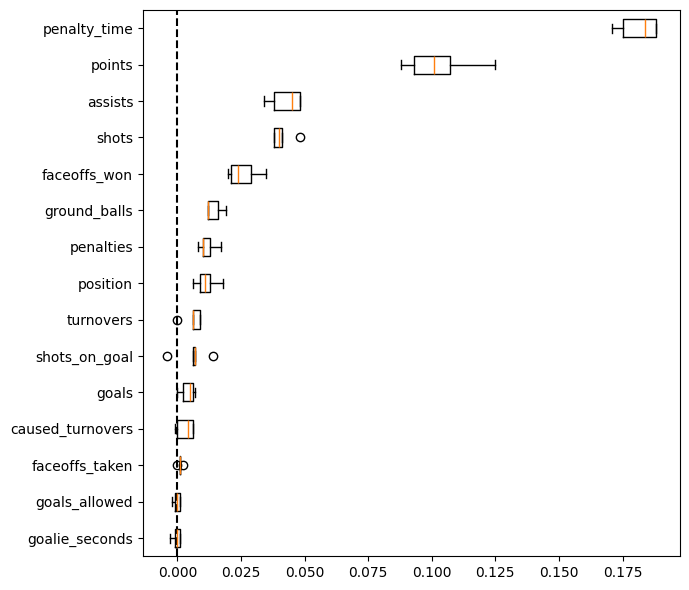

In [9]:

perm_sorted_idx = permimp.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(7, 6))
ax.boxplot(
        permimp.importances[perm_sorted_idx].T,
        vert=False,
        labels=df_noblanks.columns[perm_sorted_idx],
    )
ax.axvline(x=0, color="k", linestyle="--")
_ = ax.figure.tight_layout()

In [10]:
X_train_year1 = X_train[:130000]
y_train_year1 = y_train[:130000]

In [ ]:
xtr_yr1_df = pd.DataFrame(X_train_year1, columns=['goals', 'assists', 'points', 'shots', 'shots_on_goal',
       'ground_balls', 'turnovers',
       'caused_turnovers', 'faceoffs_won', 'faceoffs_taken', 'penalties',
       'penalty_time', 'goalie_seconds', 'goals_allowed', 'goalie_saves'])

In [11]:
permimp_yr1 = permutation_importance(knn, X_train_year1, y_train_year1, scoring='accuracy', random_state=42)
permimp_yr1

{'importances_mean': array([9.49538462e-03, 9.94461538e-03, 3.97784615e-02, 1.05124615e-01,
        5.11461538e-02, 1.12861538e-02, 1.46461538e-02, 7.73846154e-03,
        8.08769231e-03, 2.73676923e-02, 1.36923077e-04, 5.50615385e-03,
        1.97044615e-01, 9.84615385e-05, 7.23076923e-05]),
 'importances_std': array([5.38606574e-04, 4.21617062e-04, 5.71086373e-04, 1.21664394e-03,
        6.83811109e-04, 2.66975167e-04, 1.55224594e-04, 2.42326007e-04,
        2.47907217e-04, 6.43408086e-04, 2.54660698e-05, 4.09918451e-04,
        5.51692393e-04, 8.47411653e-05, 1.37311463e-04]),
 'importances': array([[ 9.61538462e-03,  9.70769231e-03,  9.08461538e-03,
          8.75384615e-03,  1.03153846e-02],
        [ 1.07461538e-02,  9.68461538e-03,  9.73846154e-03,
          9.57692308e-03,  9.97692308e-03],
        [ 3.98153846e-02,  4.06384615e-02,  3.91692308e-02,
          3.91461538e-02,  4.01230769e-02],
        [ 1.05569231e-01,  1.04876923e-01,  1.03300000e-01,
          1.04823077e-01, 

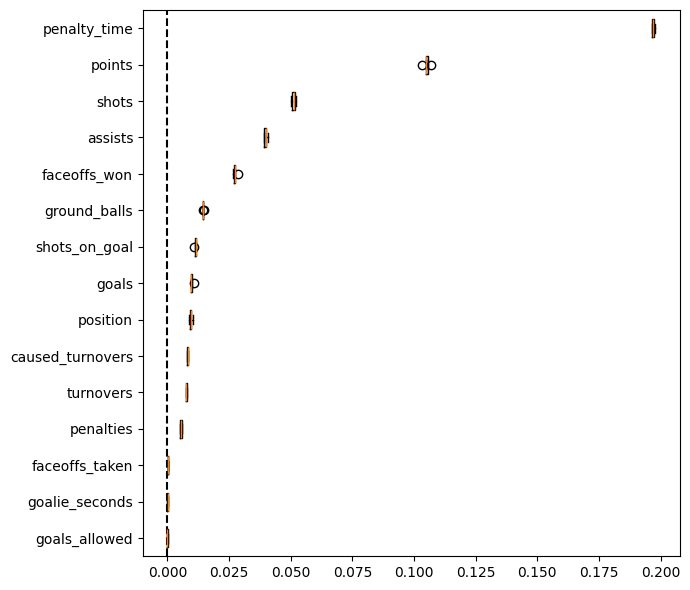

In [12]:
perm_sorted_idx_yr1 = permimp_yr1.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(7, 6))
ax.boxplot(
        permimp_yr1.importances[perm_sorted_idx_yr1].T,
        vert=False,
        labels=df_noblanks.columns[perm_sorted_idx_yr1],
    )
ax.axvline(x=0, color="k", linestyle="--")
_ = ax.figure.tight_layout()

Check precision and recall and f1 score

In [7]:
prec = precision_score(y_test, knn.predict(X_test), average='micro')
prec

0.7401858257581851

In [11]:
prec1 = precision_score(y_test, knn.predict(X_test), average=None)
prec1

array([0.6579237 , 0.77085632, 0.99814184, 0.64045072])

In [9]:
rec  = recall_score(y_test, knn.predict(X_test), average='micro')
rec

0.7401858257581851

In [12]:
rec1  = recall_score(y_test, knn.predict(X_test), average=None)
rec1

array([0.76831358, 0.94770045, 0.99613661, 0.38793519])

In [10]:
f_one = f1_score(y_test, knn.predict(X_test), average='micro')
f_one

0.7401858257581851

In [13]:
f_one1 = f1_score(y_test, knn.predict(X_test), average=None)
f_one1

array([0.70884658, 0.85017952, 0.99713822, 0.48319093])

Show predictions based on knn, uniform, 180 neighbors, with 80% training

and then show actuals

compare the two and pull 100ish where they are the same for the error analysis and why they may not be accurate